In [659]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import time
from tqdm import tqdm

# Importing machine learning libraries
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score

# Data Visualisation
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
sns.set_theme()

# Dataset

In [666]:
# Load user-level dataset
data = pd.read_csv('Dataset/all_user_data.csv')
print('Number of rows:', data.shape[0], '\nNumber of features:',data.shape[1])
data.head()

Number of rows: 37060 
Number of features: 17


id  age gender country  latitude  longitude traffic_source  \
0    457   65      M  Brazil -9.945568 -67.835610         Search   
1  64231   25      F  Brazil -9.945568 -67.835610         Search   
2  72187   47      F  Brazil -9.945568 -67.835610         Search   
3  95069   48      M  Brazil -9.857324 -69.437057         Search   
4  21246   62      M  Brazil -8.325245 -71.553030          Email   

   days_since_lo  cancellations  returns  no_orders  no_items  \
0           85.0            0.0      0.0          1         1   
1          280.0            0.0      0.0          1         1   
2           88.0            0.0      0.0          1         1   
3          645.0            1.0      1.0          1         1   
4           77.0            0.0      0.0          2         3   

   items_per_order  total_spend  avg_order_value income_category  \
0              1.0    99.989998        99.989998            high   
1              1.0    39.950001        39.950001          medium   
2              1.0    21.000000        21.000000             low   
3              1.0    39.500000        39.500000             low   
4              1.5   145.139999        72.570000            high   

   children_at_home  
0               0.0  
1               0.0  
2               1.0  
3               1.0  
4               1.0

In [249]:
# Crosstab by country and gender
pd.crosstab(data.country, data.gender).sort_values('M', ascending = False)

gender             F     M
country                   
China           6663  6835
United States   4465  4424
Brazil          2834  2837
South Korea     1057  1026
France           934   928
United Kingdom   891   925
Germany          841   826
Spain            786   788

In [667]:
# US only data
data_us = data[data.country == 'United States']
print('Number of rows for US only data:', data_us.shape[0], 
      '\nNumber of features:',data_us.shape[1])

Number of rows for US only data: 8889 
Number of features: 17


# Data exploration -  RFM features + age

In [650]:
# Descriptive statistics for key features
columns = ['age', 'days_since_lo', 'no_orders', 'total_spend']
data_us[columns].describe()

age  days_since_lo    no_orders  total_spend
count  8889.000000    8889.000000  8889.000000  8889.000000
mean     41.241984     261.918439     1.234672   107.105301
std      17.075172     202.763990     0.518392   114.474033
min      12.000000       1.000000     1.000000     1.510000
25%      26.000000      84.000000     1.000000    34.000000
50%      41.000000     216.000000     1.000000    68.000000
75%      56.000000     414.000000     1.000000   139.600000
max      70.000000     730.000000     4.000000  1228.990000

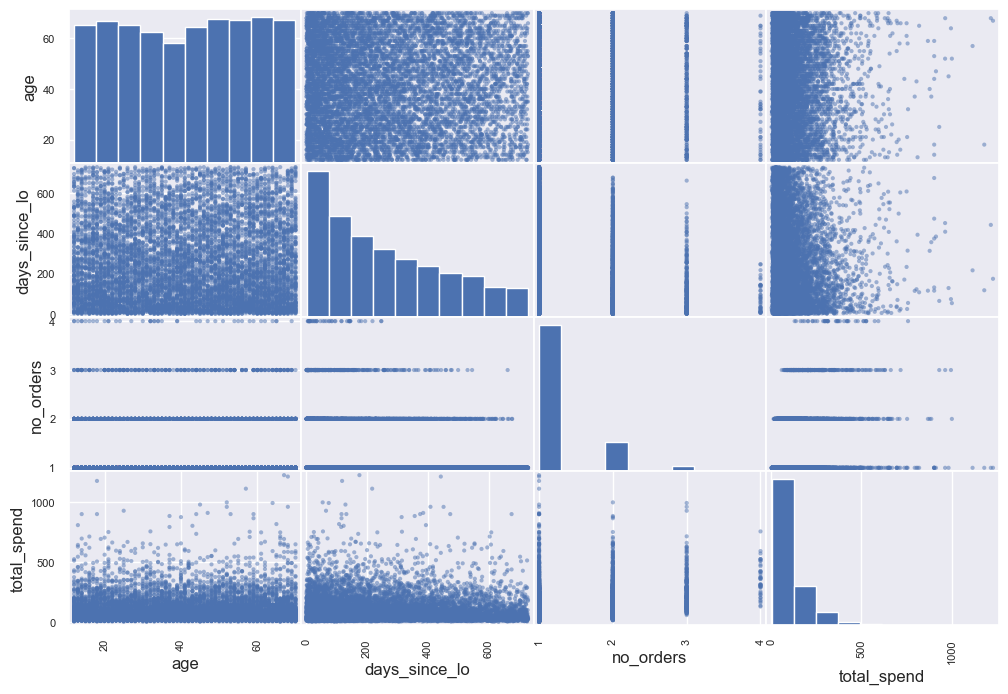

In [651]:
# Scatter matrix for the key features
scatter_matrix(data_us[columns], figsize=(12,8))
plt.show()

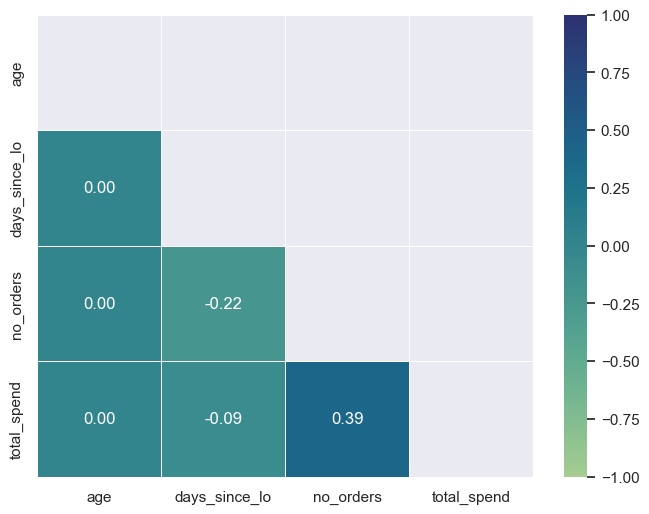

In [652]:
# Correlation matrix for key features
corr = data_us[columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(8,6))
sns.heatmap(data[columns].corr(), mask = mask,annot=True, fmt=".2f", 
            cmap="crest", linewidth=.5, vmin=-1, vmax=1)
plt.grid(visible = None)
plt.show()

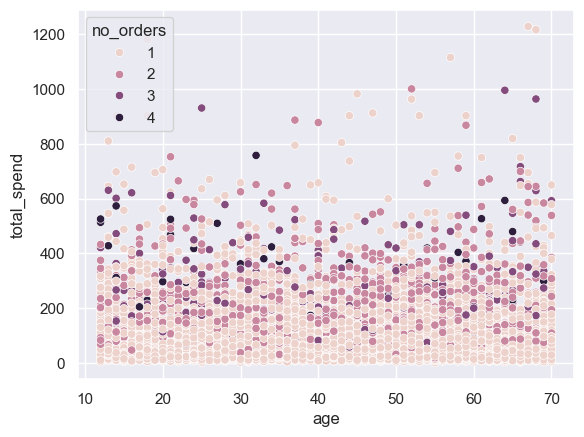

In [271]:
# Scatterplot of US data
sns.scatterplot(data = data_us, x = 'age', y = 'total_spend' , hue =  'no_orders' )
plt.show()

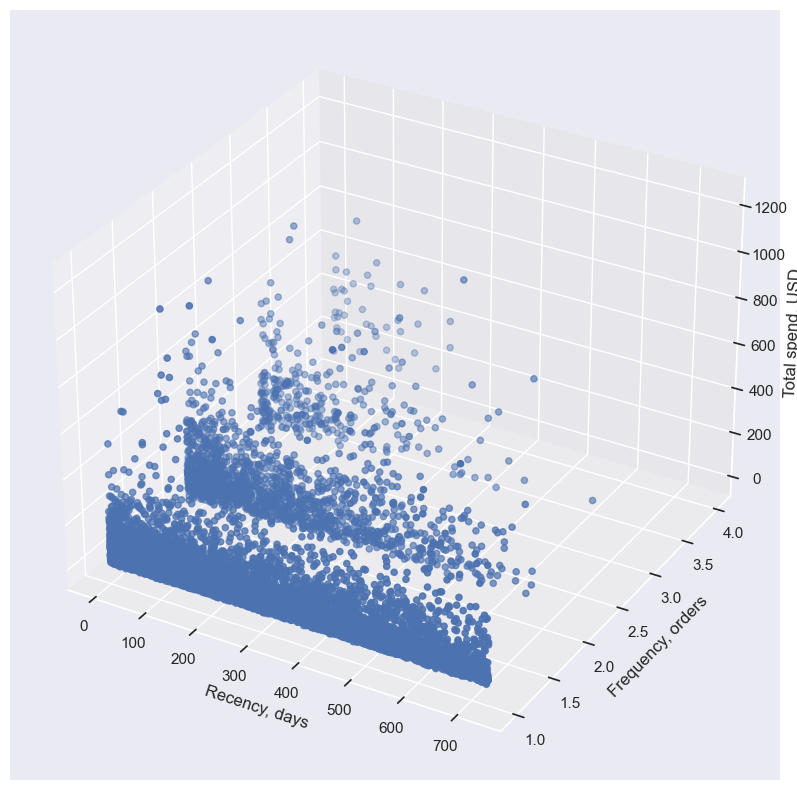

In [658]:
# Visualising US data on 3D plot - RFM features
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.set_size_inches(14, 10)

ax.scatter(data_us.days_since_lo, data_us.no_orders, data_us.total_spend 
           )
ax.set_xlabel('Recency, days')
ax.set_ylabel('Frequency, orders')
ax.set_zlabel('Total spend, USD')
plt.show()

# Preprocessing - US data
## Encoding of categorical values

In [668]:
# Drop columns that won't be used for modelling
data_us = data_us.drop(columns =['country', 'id'])
data_us = data_us.reset_index(drop = True)

# Change income categories to numeric values based on the income level
data_us['income_category'].replace(['none', 'low', 'medium', 'high'],
                        [0, 1, 2, 3], inplace=True)

# One Hot Encoding of gender and traffic_source
#Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')

categorical_columns = ['gender', 'traffic_source']

# Apply one-hot encoding to the categorical columns
one_hot_encoded = encoder.fit_transform(data_us[categorical_columns])

#Create a DataFrame with the one-hot encoded columns
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Join tables
data_us = pd.concat([data_us,one_hot_df], axis = 1)

# Drop columns that were encoded
data_us = data_us.drop(columns =['gender', 'traffic_source'])
data_us.head()

age   latitude  longitude  days_since_lo  cancellations  returns  \
0   44  31.263350 -85.391113          118.0            0.0      0.0   
1   18  31.263350 -85.391113          109.0            0.0      0.0   
2   20  32.497118 -85.483097          584.0            0.0      0.0   
3   24  33.366990 -86.096994          270.0            0.0      0.0   
4   15  33.366990 -86.096994          376.0            0.0      0.0   

   no_orders  no_items  items_per_order  total_spend  avg_order_value  \
0          1         1              1.0        54.00            54.00   
1          1         1              1.0        80.00            80.00   
2          1         1              1.0        13.64            13.64   
3          1         1              1.0        94.00            94.00   
4          1         1              1.0       140.00           140.00   

   income_category  children_at_home  gender_M  traffic_source_Email  \
0                1               1.0       1.0                   0.0   
1                1               0.0       0.0                   0.0   
2                1               0.0       1.0                   0.0   
3                1               0.0       0.0                   0.0   
4                0               0.0       0.0                   0.0   

   traffic_source_Facebook  traffic_source_Organic  traffic_source_Search  
0                      0.0                     1.0                    0.0  
1                      0.0                     0.0                    1.0  
2                      0.0                     0.0                    1.0  
3                      0.0                     0.0                    1.0  
4                      0.0                     0.0                    1.0

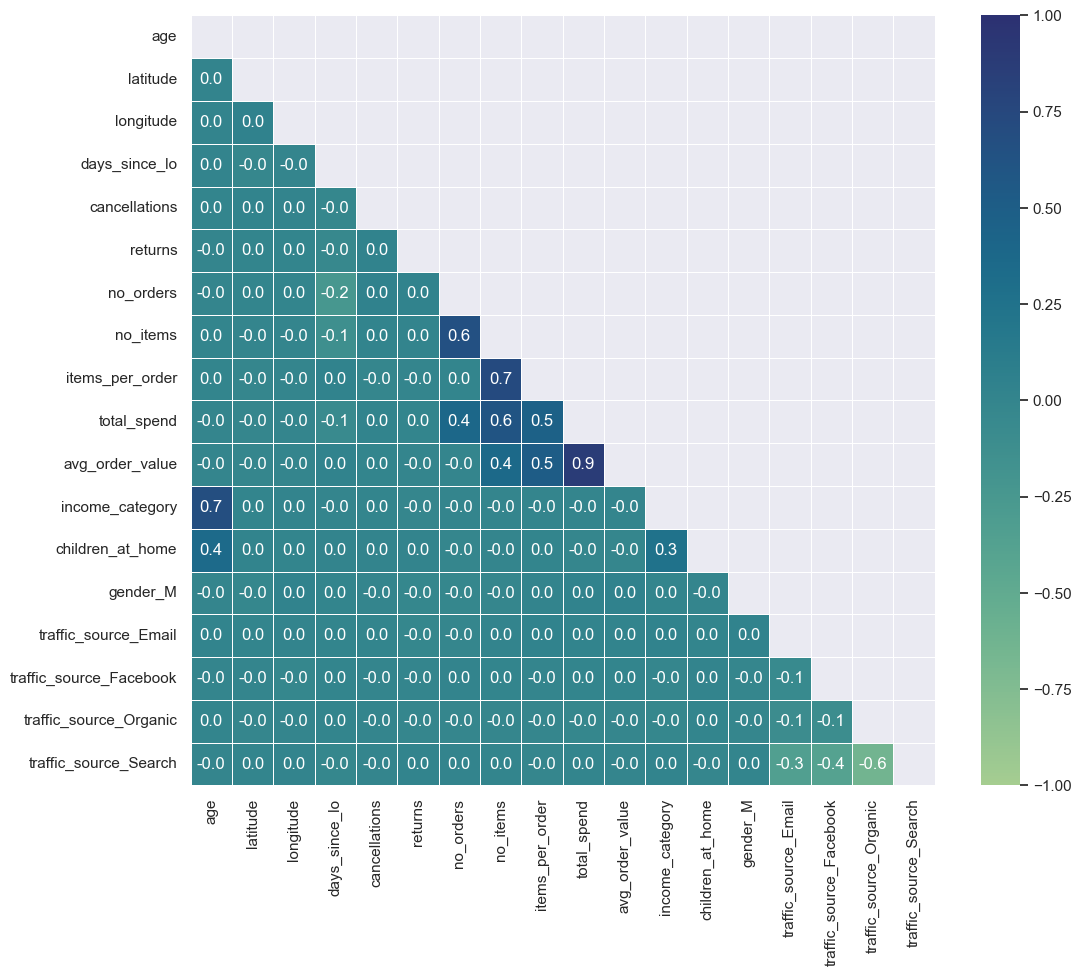

In [669]:
# Correlation matrix for all US features
corr = data_us.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12,10))
sns.heatmap(corr, mask = mask,annot=True, fmt=".1f", 
            cmap="crest", linewidth=.5, vmin=-1, vmax=1)
plt.grid(visible = None)
plt.show()

### Scaling data

In [285]:
# Create scaler
scaler = MinMaxScaler()
us_scaled = scaler.fit_transform(data_us)

# T-SNE  
## All features

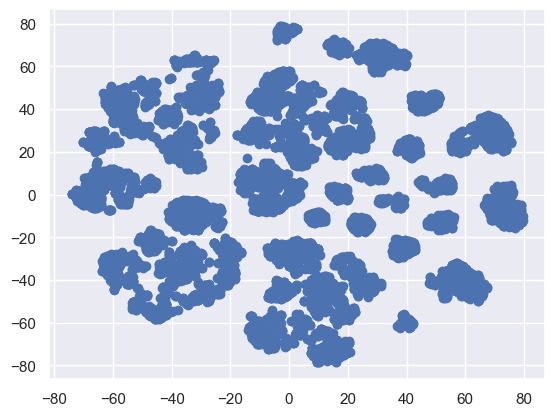

In [308]:
# Create a TSNE instance - experiment with values between 50 and 200
model = TSNE(learning_rate = 100)

# Apply fit_transform to scaled features
tsne_features = model.fit_transform(us_scaled)

# Select the 0th feature
xs = tsne_features[:,0]

# Select the 1st feature
ys = tsne_features[:,1]

# Scatter plot
plt.scatter(xs, ys) 
plt.show()

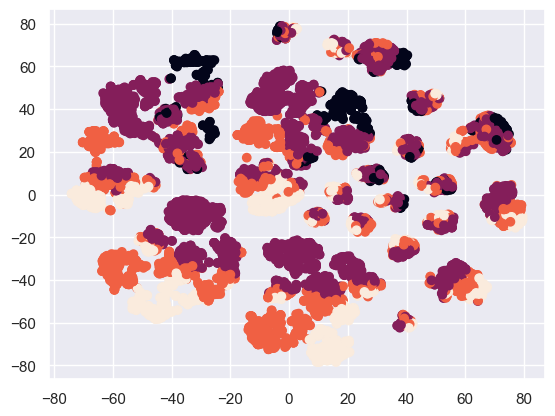

In [309]:
# t-SNE scatter plot, coloured by number income category
plt.scatter(xs, ys, c = data_us.income_category) 
plt.show()

## Numeric features

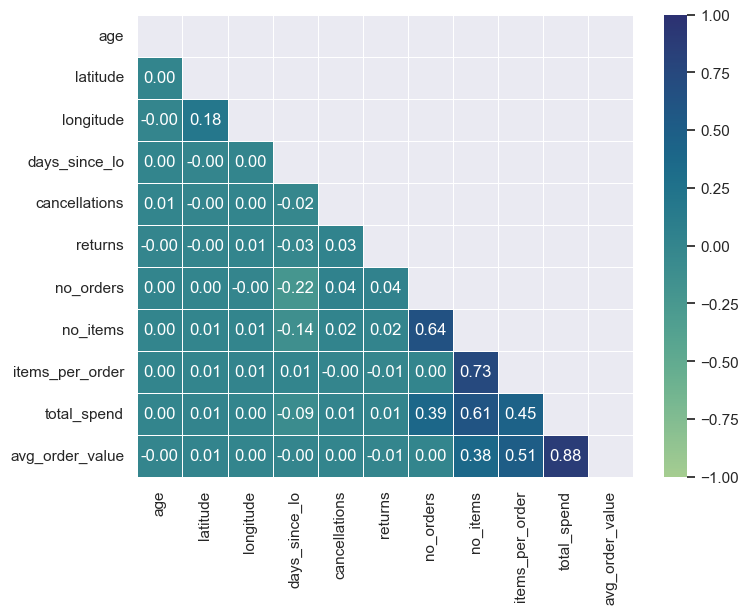

In [310]:
# Only numeric features
numeric_columns = ['age', 'latitude', 'longitude', 'days_since_lo', 'cancellations',
                  'returns', 'no_orders', 'no_items', 'items_per_order', 'total_spend',
                  'avg_order_value']

# Correlation matrix for key features
corr = data_us[numeric_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(8,6))
sns.heatmap(corr, mask = mask,annot=True, fmt=".2f", 
            cmap="crest", linewidth=.5, vmin=-1, vmax=1)
plt.grid(visible = None)
plt.show()

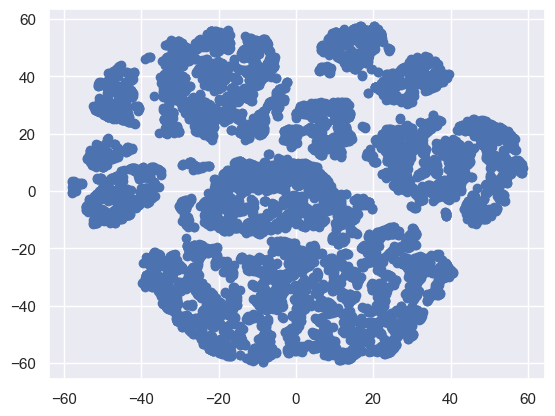

In [311]:
# Create scaler
scaler = MinMaxScaler()
us_scaled_numeric = scaler.fit_transform(data_us[numeric_columns])

# Create a TSNE instance
model = TSNE(learning_rate = 50)

# Apply fit_transform to scaled numeric features
tsne_features = model.fit_transform(us_scaled_numeric)

# Select the 0th feature
xs = tsne_features[:,0]

# Select the 1st feature
ys = tsne_features[:,1]

# Scatter plot
plt.scatter(xs, ys) 
plt.show()

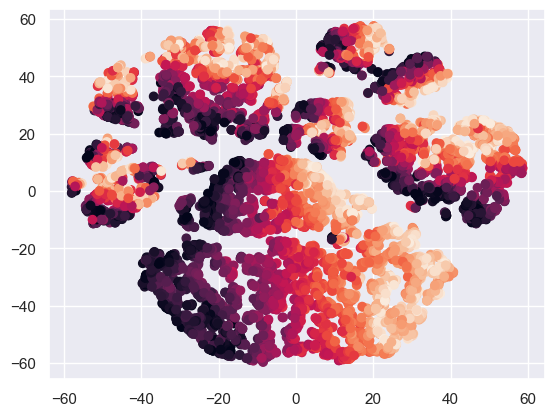

In [328]:
# Scatter plot, colored by age
plt.scatter(xs, ys, c = us_scaled_numeric[:,[0]]) 
plt.show()

## RFM features

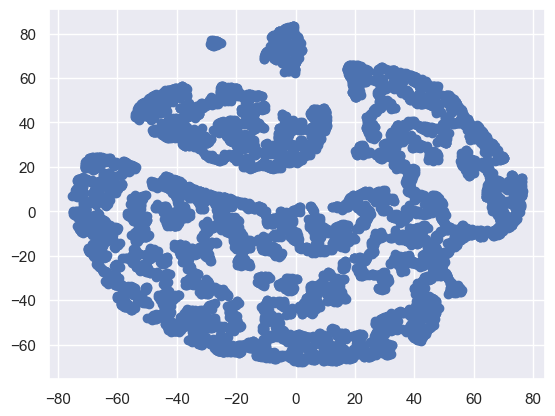

In [353]:
# RFM columns
sample_columns = ['no_orders','days_since_lo', 'total_spend']

# Create scaler
scaler = MinMaxScaler()
sample_scaled = scaler.fit_transform(data_us[sample_columns])

# Create a TSNE instance
model = TSNE(learning_rate = 100)

# Apply fit_transform to scaled RFM features
tsne_features = model.fit_transform(sample_scaled)

# Select the 0th feature
xs = tsne_features[:,0]

# Select the 1st feature
ys = tsne_features[:,1]

# Scatter plot
plt.scatter(xs, ys) 
plt.show()

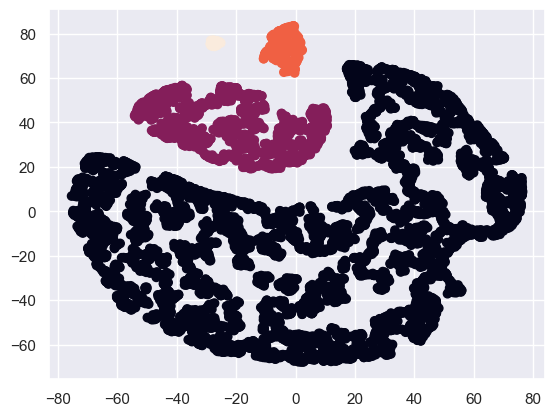

In [357]:
# Scatter plot, colored by number of orders
plt.scatter(xs, ys, c = data_us.no_orders) 
plt.show()

# PCA

Variance explained by top 3 features 0.8173473779773266


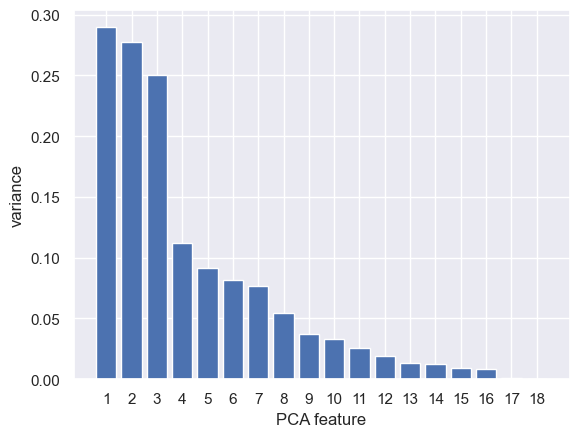

In [373]:
# PCA for all features

# Create scaler
scaler = MinMaxScaler()

# Create a PCA instance
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, pca)

# Fit the pipeline to US data
pipeline.fit(data_us)

# Explained variance by sum of top 3 features
print('Variance explained by top 3 features', pca.explained_variance_[:3].sum())

# Plot the explained variances
features = range(1, pca.n_components_ +1)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

Variance explained by top 3 features 0.24559675292876057


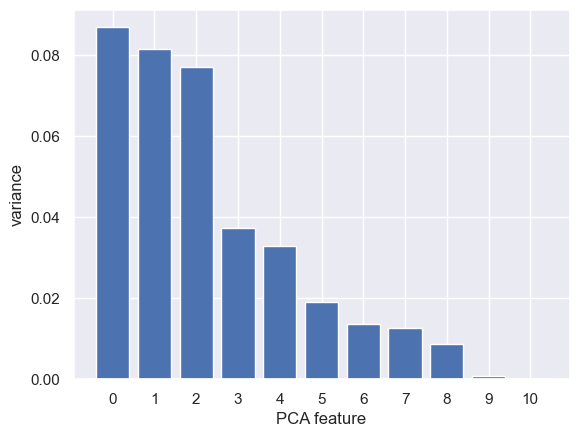

In [365]:
# PCA - Only numeric features
numeric_columns = ['age', 'latitude', 'longitude', 'days_since_lo', 'cancellations',
                  'returns', 'no_orders', 'no_items', 'items_per_order', 'total_spend',
                  'avg_order_value']

# Create scaler
scaler = MinMaxScaler()

# Create a PCA instance
pca = PCA()

# Create pipeline
pipeline = make_pipeline(scaler, pca)

# Fit the pipeline to numeric features
pipeline.fit(data_us[numeric_columns])

# Explained variance by sum of top 3 features
print('Variance explained by top 3 features', pca.explained_variance_[:3].sum())


# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [374]:
# Dimension reduction based on all features with 3 components

scaler = MinMaxScaler()

# Create a PCA model with 3 components
pca = PCA(n_components = 3)

# Create pipeline
pipeline = make_pipeline(scaler, pca)

# Fit the pipeline to US data
pipeline.fit(data_us)

# Transform the scaled samples
pca_features = pipeline.transform(data_us)

# Print the shape of pca_features
print(pca_features.shape)

(8889, 3)


# Clustering - PCA features
## K-Means

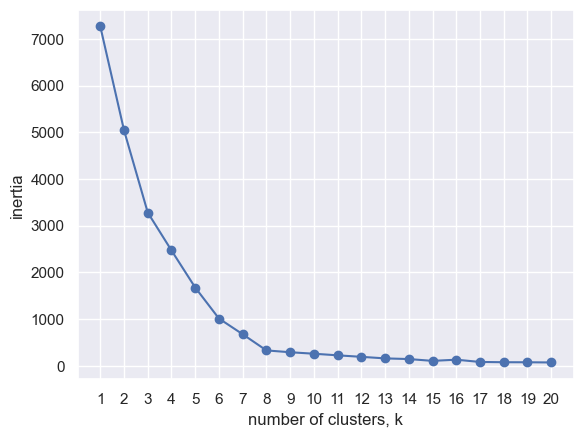

In [379]:
# Training model with PCA features to find optimal number of clusters
ks = range(1, 21)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters
    model = KMeans(n_clusters = k, n_init = 'auto')
    
    # Fit model to pca features
    model.fit(pca_features)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

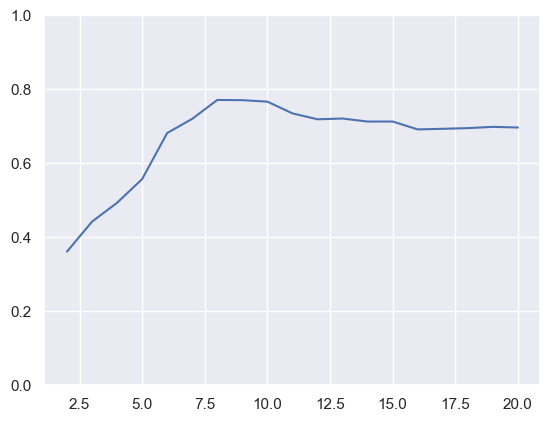

In [397]:
# Evaluation of optimal number of clusters based on silhouette score
ks = range(2, 21)
score = []


for k in ks:
    # train the model for current value of k on training data
    model = KMeans(n_clusters = k, random_state = 0, n_init='auto').fit(pca_features)
    
    # Predict the cluster labels
    labels = model.predict(pca_features)
    
    # Append the silhouette score to scores
    score.append(silhouette_score(pca_features, labels, metric='euclidean'))
    
sns.lineplot(x = ks, y = score)
plt.ylim(0, 1)
plt.show()

In [660]:
start_time = time.time()

# Create a KMeans instance with 8 clusters
model = KMeans(n_clusters = 8, n_init = 'auto', random_state = 42)
    
# Fit model to pca features
model.fit(pca_features)

# Predict the cluster labels: labels
labels = model.predict(pca_features)

end_time = time.time()
execution_time = end_time - start_time

# Print performance metrics
print("KMeans execution time:", execution_time, "seconds")
print("Model's inertia:" , model.inertia_)
print("Model's Silhouette score:" , silhouette_score(pca_features, labels, metric='euclidean'))
print("Model's Davies-Bouldin Index:" , davies_bouldin_score(pca_features, labels))

KMeans execution time: 0.05765104293823242 seconds
Model's inertia: 328.05491757636446
Model's Silhouette score: 0.7707137731591349
Model's Davies-Bouldin Index: 0.4350926240798506


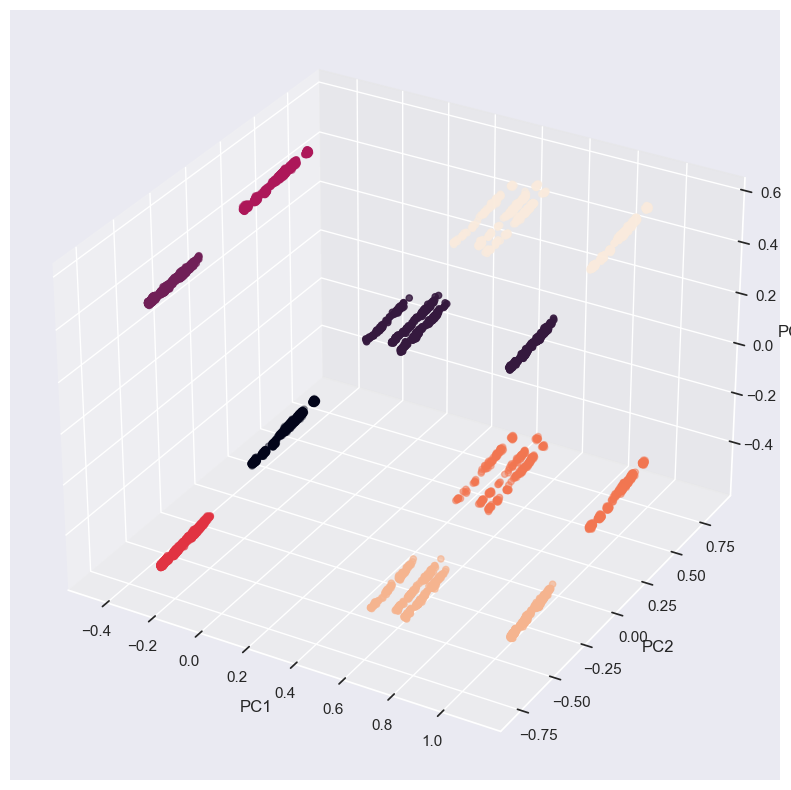

In [503]:
# PC features coloured by cluster labels
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.set_size_inches(14, 10)

ax.scatter(pca_features[:,[0]], pca_features[:,[1]], pca_features[:,[2]], 
           c = labels)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

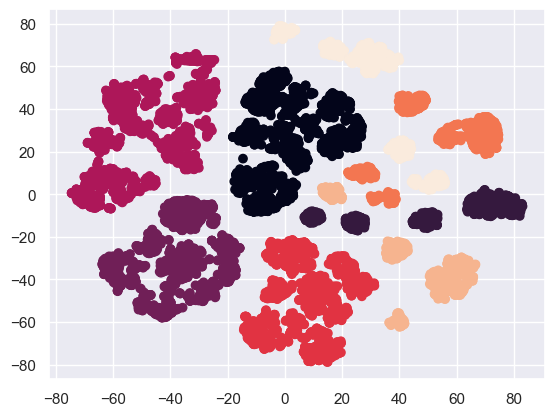

In [504]:
# Create a TSNE instance
model = TSNE(learning_rate = 100)

# Apply fit_transform to US scaled data
tsne_features = model.fit_transform(us_scaled)

# Select the 0th feature
xs = tsne_features[:,0]

# Select the 1st feature
ys = tsne_features[:,1]

# Scatter plot coloured by labels
plt.scatter(xs, ys, c = labels) 
plt.show()

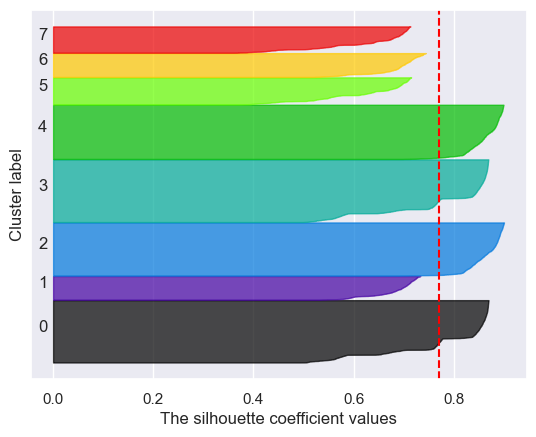

In [440]:
# The silhouette plot 
# Source: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
sample_silhouette_values = silhouette_samples(pca_features, labels)
silhouette_avg = silhouette_score(pca_features, labels, metric='euclidean')
clusters = 8
y_lower = 10

for i in range(clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i)/ clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for indentation

#plt.title("The silhouette plot for the various clusters.")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

# The vertical line for average silhouette score of all values
plt.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.yticks([])  # Hide ticks
plt.show()

# Agglomerative (Hierarchical)
https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering

In [661]:
start_time = time.time()

# Create a AgglomerativeClustering instance and fit data
ac_model = AgglomerativeClustering(linkage = 'average').fit(pca_features)

# Predict labels
ac_labels = ac_model.labels_

end_time = time.time()
execution_time = end_time - start_time

# Print performance metrics
print("AgglomerativeClustering execution time:", execution_time, "seconds")

# Number of clusters generated
cluster_no = len(set(ac_labels))
print('Number of clusters:', cluster_no)
print("Model's Silhouette score:" , silhouette_score(pca_features, ac_labels, metric='euclidean'))
print("Model's Davies-Bouldin Index:" , davies_bouldin_score(pca_features, ac_labels))

AgglomerativeClustering execution time: 1.0691509246826172 seconds
Number of clusters: 2
Model's Silhouette score: 0.3856364789144675
Model's Davies-Bouldin Index: 1.2935425948089199


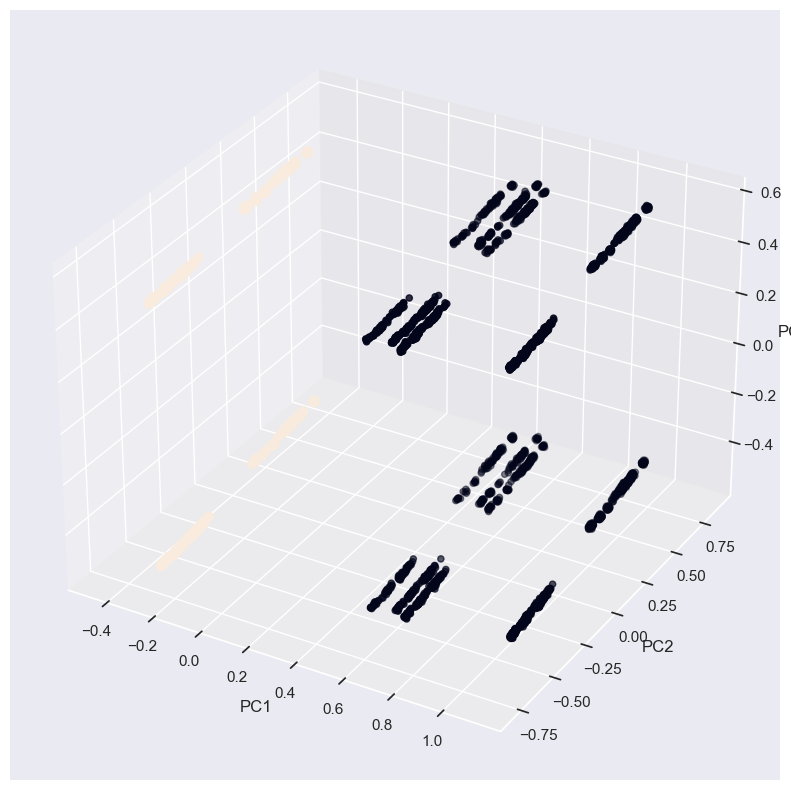

In [493]:
# PC features coloured by cluster labels
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.set_size_inches(14, 10)

ax.scatter(pca_features[:,[0]], pca_features[:,[1]], pca_features[:,[2]], 
           c = ac_labels)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

# Mean Shift
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html#sklearn.cluster.MeanShift

100%|█████████████████████████████████████████████| 8/8 [00:44<00:00,  5.62s/it]


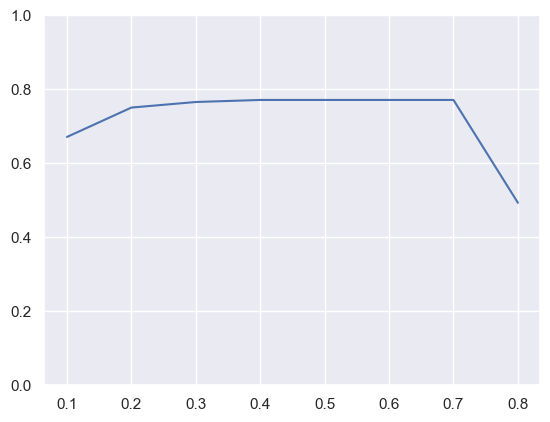

In [466]:
# Range of Bandwidth values
bandwidth_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

score = []
cluster_counts = []

# Evaluate model for optimal Bandwidth
for bandwidth in tqdm(bandwidth_range):
    # train the model for current value of k on training data
    ms_model = MeanShift(bandwidth = bandwidth).fit(pca_features)
    
    # Predict the cluster labels
    ms_labels = ms_model.predict(pca_features)
    
    # Number of clusters generated
    cluster_no = len(set(ms_labels))
    cluster_counts.append(cluster_no)
    
    # Append the silhouette score to scores
    score.append(silhouette_score(pca_features, ms_labels, metric='euclidean'))
    
sns.lineplot(x = bandwidth_range, y = score)
plt.xlabel('Bandwidth')
plt.ylabel('Silhouette Score')
plt.ylim(0, 1)
plt.xlim(0, 0.9)
plt.show()

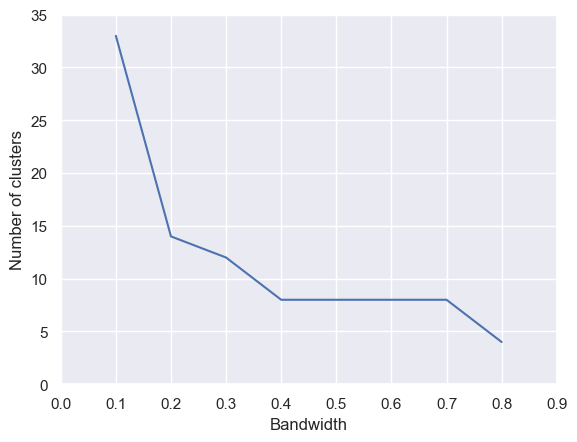

In [475]:
# Number of clusters by Bandwidth
sns.lineplot(x = bandwidth_range, y = cluster_counts)
plt.xlabel('Bandwidth')
plt.ylabel('Number of clusters')
plt.ylim(0, 35)
plt.xlim(0, 0.9)
plt.show()

In [662]:
start_time = time.time()

# Model with the best bandwidth value 
ms_model = MeanShift(bandwidth = 0.4).fit(pca_features)
    
# Predict the cluster labels: labels
ms_labels = ms_model.predict(pca_features)

end_time = time.time()
execution_time = end_time - start_time

# Print performance metrics
print("MeanShift execution time:", execution_time, "seconds")
    
# Number of clusters generated
cluster_no = len(set(ms_labels))
print('Number of clusters:', cluster_no)
print("Model's Silhouette score:" , silhouette_score(pca_features, ms_labels, metric='euclidean'))
print("Model's Davies-Bouldin Index:" , davies_bouldin_score(pca_features, ms_labels))

MeanShift execution time: 3.8475289344787598 seconds
Number of clusters: 8
Model's Silhouette score: 0.7707137731591349
Model's Davies-Bouldin Index: 0.43509262407985055


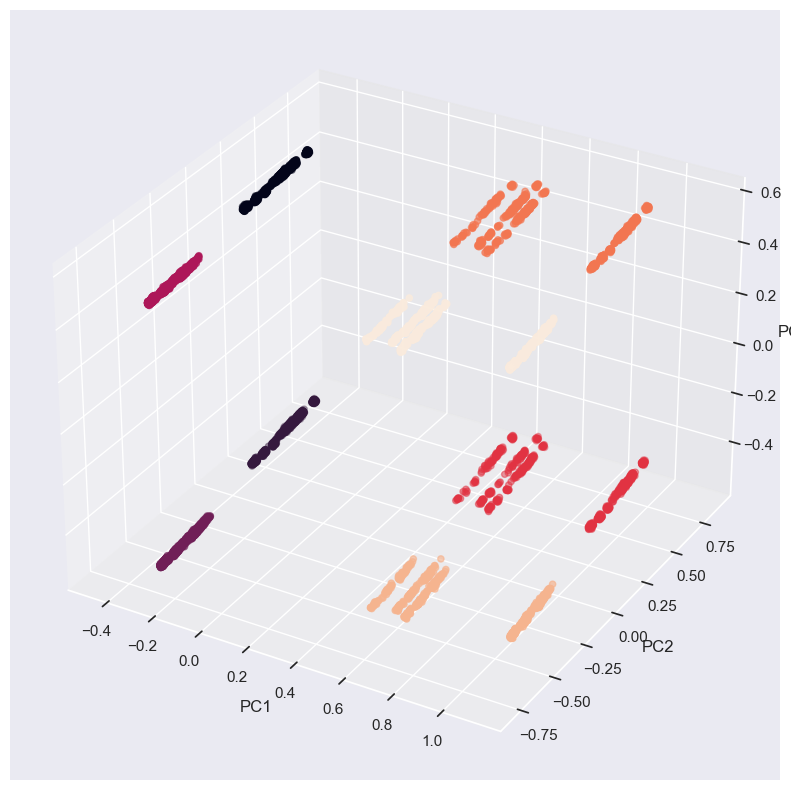

In [484]:
# PC features coloured by cluster labels
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.set_size_inches(14, 10)

ax.scatter(pca_features[:,[0]], pca_features[:,[1]], pca_features[:,[2]], 
           c = ms_labels)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

# DBSCAN
https://scikit-learn.org/dev/auto_examples/cluster/plot_dbscan.html

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]


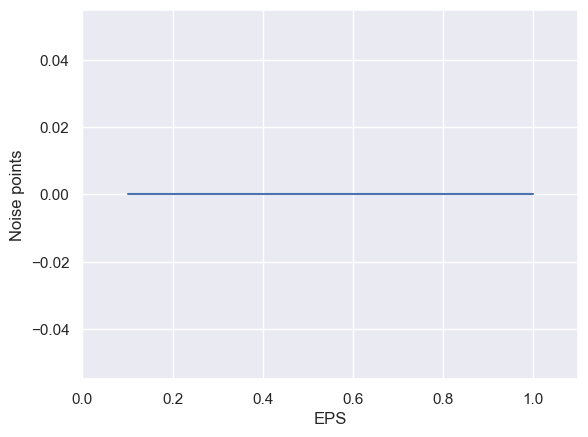

In [616]:
# Range of epsilon values
eps_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

n_clusters = []
n_noise = []

# Evaluate model for optimal epsilon
for eps in tqdm(eps_range):
    # train the model for current value of k on training data
    db = DBSCAN(eps = eps, min_samples = 10).fit(pca_features)

    
    # Predict the cluster labels
    db_labels = db.labels_
    
    # Number of clusters in labels, ignoring noise if present
    n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
    n_clusters.append(n_clusters_)
    n_noise_ = list(db_labels).count(-1)
    n_noise.append(n_noise_)
    
    
sns.lineplot(x = eps_range, y = n_noise)
plt.xlabel('EPS')
plt.ylabel('Noise points')
plt.xlim(0, 1.1)
plt.show()

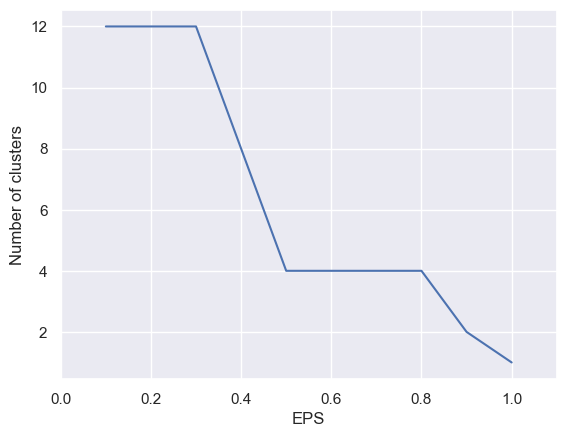

In [617]:
# Number of clusters by epsilon
sns.lineplot(x = eps_range, y = n_clusters)
plt.xlabel('EPS')
plt.ylabel('Number of clusters')
plt.xlim(0, 1.1)
plt.show()

In [663]:
start_time = time.time()

# Model with the best eps value 
db = DBSCAN(eps=0.3, min_samples=10).fit(pca_features)

# Predict the cluster labels
db_labels = db.labels_

end_time = time.time()
execution_time = end_time - start_time

# Print performance metrics
print("DBSCAN execution time:", execution_time, "seconds")

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise_ = list(db_labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Model's Silhouette score:" , silhouette_score(pca_features, db_labels, metric='euclidean'))
print("Model's Davies-Bouldin Index:" , davies_bouldin_score(pca_features, db_labels))

DBSCAN execution time: 0.18241095542907715 seconds
Estimated number of clusters: 12
Estimated number of noise points: 0
Model's Silhouette score: 0.7651650795160743
Model's Davies-Bouldin Index: 0.47353597459495794


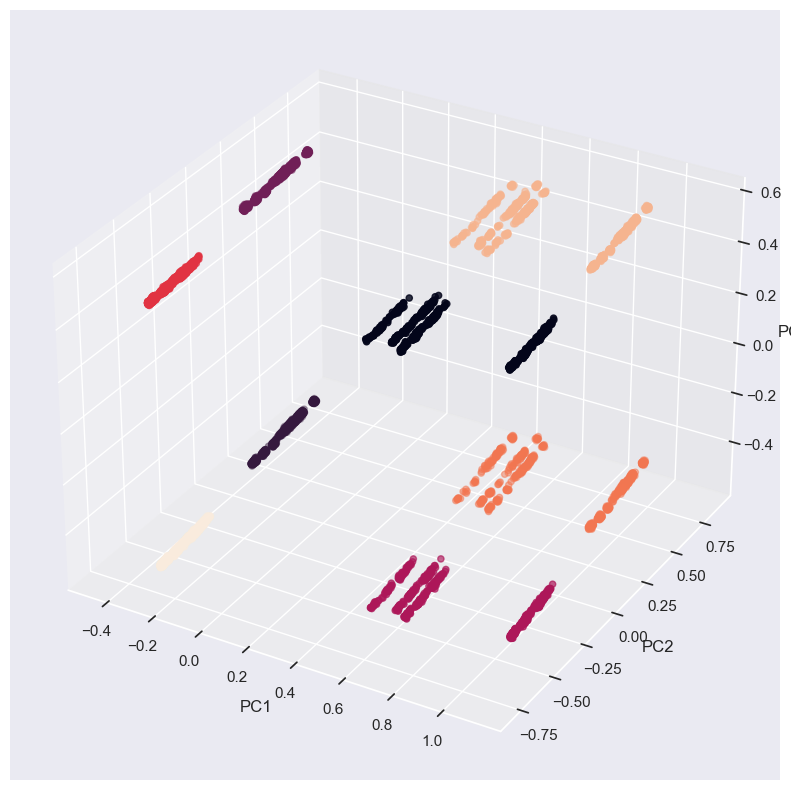

In [625]:
# PC features coloured by cluster labels
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.set_size_inches(14, 10)

ax.scatter(pca_features[:,[0]], pca_features[:,[1]], pca_features[:,[2]], 
           c = db_labels)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

# Cluster Analysis for PCA

In [670]:
# Create dataframe for labels
us_labeled = data_us
# Add labels for all models
us_labeled.loc[:, 'km_labels'] = labels
us_labeled.loc[:, 'ms_labels'] = ms_labels
us_labeled.loc[:, 'ac_labels'] = ac_labels
us_labeled.loc[:, 'db_labels'] = db_labels

us_labeled.head()

age   latitude  longitude  days_since_lo  cancellations  returns  \
0   44  31.263350 -85.391113          118.0            0.0      0.0   
1   18  31.263350 -85.391113          109.0            0.0      0.0   
2   20  32.497118 -85.483097          584.0            0.0      0.0   
3   24  33.366990 -86.096994          270.0            0.0      0.0   
4   15  33.366990 -86.096994          376.0            0.0      0.0   

   no_orders  no_items  items_per_order  total_spend  ...  children_at_home  \
0          1         1              1.0        54.00  ...               1.0   
1          1         1              1.0        80.00  ...               0.0   
2          1         1              1.0        13.64  ...               0.0   
3          1         1              1.0        94.00  ...               0.0   
4          1         1              1.0       140.00  ...               0.0   

   gender_M  traffic_source_Email  traffic_source_Facebook  \
0       1.0                   0.0                      0.0   
1       0.0                   0.0                      0.0   
2       1.0                   0.0                      0.0   
3       0.0                   0.0                      0.0   
4       0.0                   0.0                      0.0   

   traffic_source_Organic  traffic_source_Search  km_labels  ms_labels  \
0                     1.0                    0.0          1          7   
1                     0.0                    1.0          0          1   
2                     0.0                    1.0          3          0   
3                     0.0                    1.0          0          1   
4                     0.0                    1.0          0          1   

   ac_labels  db_labels  
0          0          0  
1          1          1  
2          1          2  
3          1          1  
4          1          1  

[5 rows x 22 columns]

In [673]:
# Cluster size K-means
us_labeled[['age', 'km_labels']].groupby('km_labels').count()

age
km_labels      
0          1662
1           633
2          1418
3          1672
4          1446
5           720
6           637
7           701

In [676]:
# Categorical values by cluster
columns = ['gender_M','traffic_source_Email','traffic_source_Facebook',
          'traffic_source_Organic', 'traffic_source_Search',
          'children_at_home'
          ]
us_labeled.groupby('km_labels')[columns].sum()

gender_M  traffic_source_Email  traffic_source_Facebook  \
km_labels                                                            
0               0.0                   0.0                      0.0   
1             633.0                 111.0                    132.0   
2            1418.0                   0.0                      0.0   
3            1672.0                   0.0                      0.0   
4               0.0                   0.0                      0.0   
5               0.0                  95.0                    151.0   
6               0.0                 101.0                    137.0   
7             701.0                 137.0                    125.0   

           traffic_source_Organic  traffic_source_Search  children_at_home  
km_labels                                                                   
0                             0.0                 1662.0               0.0  
1                           304.0                    0.0             633.0  
2                             0.0                 1418.0            1418.0  
3                             0.0                 1672.0               0.0  
4                             0.0                 1446.0            1446.0  
5                           362.0                    0.0               0.0  
6                           325.0                    0.0             637.0  
7                           351.0                    0.0               0.0

In [677]:
# RFM values by cluster
columns = ['age','days_since_lo', 'no_orders','total_spend'
          ]
us_labeled.groupby('km_labels')[columns].median()

age  days_since_lo  no_orders  total_spend
km_labels                                             
0          28.0          210.0        1.0    64.000000
1          48.0          241.0        1.0    69.949997
2          49.0          211.0        1.0    68.000000
3          28.0          211.5        1.0    69.989998
4          50.0          213.5        1.0    68.000000
5          29.0          227.5        1.0    66.084999
6          49.0          223.0        1.0    63.990002
7          29.0          218.0        1.0    79.500000

# Clustering - All Features

## K-means

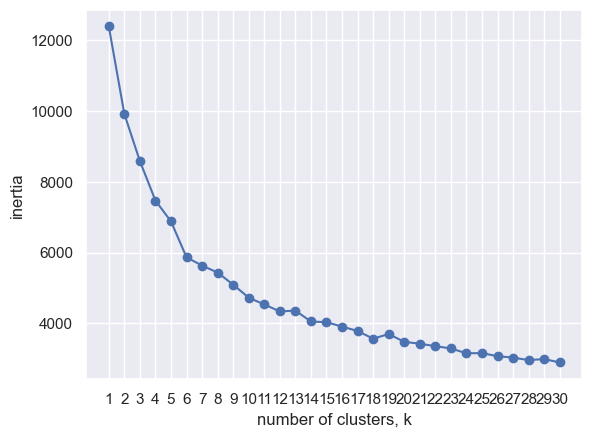

In [506]:
# Training model with all features
ks = range(1, 31)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters
    model = KMeans(n_clusters = k, n_init = 'auto')
    
    # Fit model to pca features
    model.fit(us_scaled)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

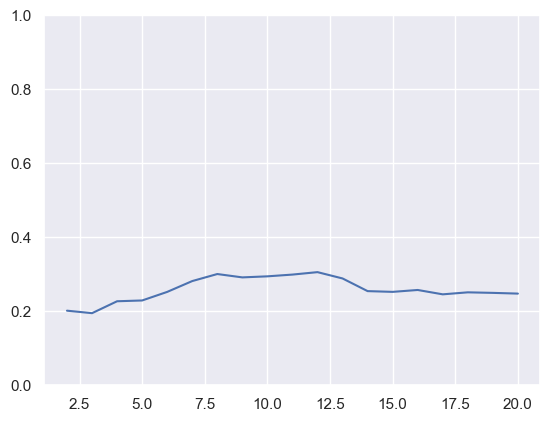

In [509]:
# Evaluation of optimal number of clusters based on silhouette score
ks = range(2, 21)
score = []


for k in ks:
    # train the model for current value of k on training data
    model = KMeans(n_clusters = k, random_state = 0, n_init='auto').fit(us_scaled)
    
    # Predict the cluster labels: labels
    labels = model.predict(us_scaled)
    
    # Append the silhouette score to scores
    score.append(silhouette_score(us_scaled, labels, metric='euclidean'))
    
sns.lineplot(x = ks, y = score)
plt.ylim(0, 1)
plt.xlim(1, 21)
plt.show()

In [636]:
start_time = time.time()

# Create a KMeans instance with 12 clusters
model = KMeans(n_clusters = 12, n_init = 'auto', random_state = 42)
    
# Fit model to all features
model.fit(us_scaled)

# Predict the cluster labels: labels
labels = model.predict(us_scaled)

end_time = time.time()
execution_time = end_time - start_time

# Print performance metrics
print("KMeans execution time:", execution_time, "seconds")
print("Model's inertia:" , model.inertia_)
print("Model's Silhouette score:" , silhouette_score(us_scaled, labels, metric='euclidean'))
print("Model's Davies-Bouldin Index:" , davies_bouldin_score(us_scaled, labels))

KMeans execution time: 0.054830074310302734 seconds
Model's inertia: 4287.266487541531
Model's Silhouette score: 0.2594073565474476
Model's Davies-Bouldin Index: 1.507577440195406


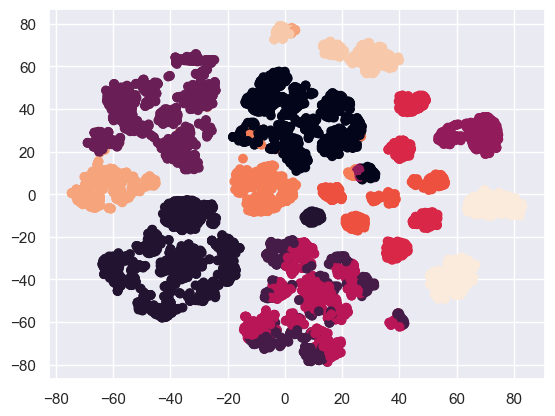

In [519]:
# Select the 0th feature
xs = tsne_features[:,0]

# Select the 1st feature
ys = tsne_features[:,1]

# Scatter plot coloured by labels
plt.scatter(xs, ys, c = labels) 
plt.show()

## Agglomerative 

In [637]:
start_time = time.time()

# Create a AgglomerativeClustering instance and fit data
ac_model = AgglomerativeClustering().fit(us_scaled)

# Predict labels
ac_labels = ac_model.labels_

end_time = time.time()
execution_time = end_time - start_time

# Print performance metrics
print("AgglomerativeClustering execution time:", execution_time, "seconds")

# Number of clusters generated
cluster_no = len(set(ac_labels))
print('Number of clusters:', cluster_no)
print("Model's Silhouette score:" , silhouette_score(us_scaled, ac_labels, metric='euclidean'))
print("Model's Davies-Bouldin Index:" , davies_bouldin_score(us_scaled, ac_labels))

AgglomerativeClustering execution time: 1.2531421184539795 seconds
Number of clusters: 2
Model's Silhouette score: 0.25289239057694435
Model's Davies-Bouldin Index: 1.8968000447780695


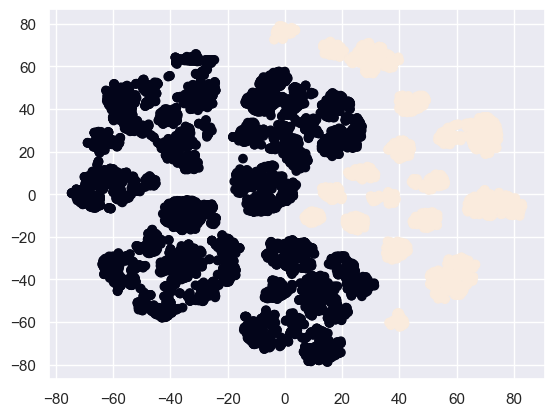

In [528]:
# Select the 0th feature
xs = tsne_features[:,0]

# Select the 1st feature
ys = tsne_features[:,1]

# Scatter plot colored by labels
plt.scatter(xs, ys, c = ac_labels) 
plt.show()

## Mean Shift

100%|████████████████████████████████████████████| 8/8 [17:03<00:00, 127.92s/it]


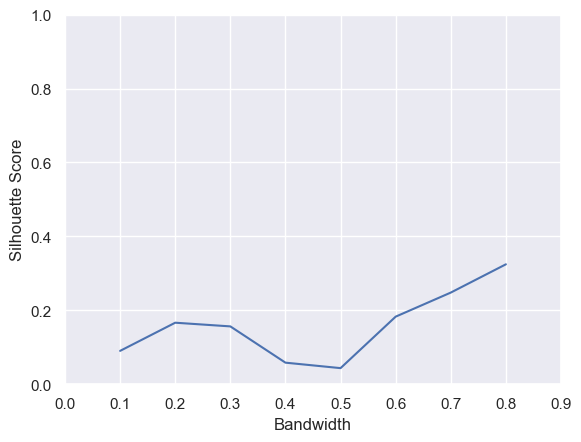

In [529]:
# Range of Bandwidth values
bandwidth_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

score = []
cluster_counts = []

# Finding optimal Bandwidth 
for bandwidth in tqdm(bandwidth_range):
    # train the model for current value of k on training data
    ms_model = MeanShift(bandwidth = bandwidth).fit(us_scaled)
    
    # Predict the cluster labels
    ms_labels = ms_model.predict(us_scaled)
    
    # Number of clusters generated
    cluster_no = len(set(ms_labels))
    cluster_counts.append(cluster_no)
    
    # Append the silhouette score to scores
    score.append(silhouette_score(us_scaled, ms_labels, metric='euclidean'))
    
sns.lineplot(x = bandwidth_range, y = score)
plt.xlabel('Bandwidth')
plt.ylabel('Silhouette Score')
plt.ylim(0, 1)
plt.xlim(0, 0.9)
plt.show()

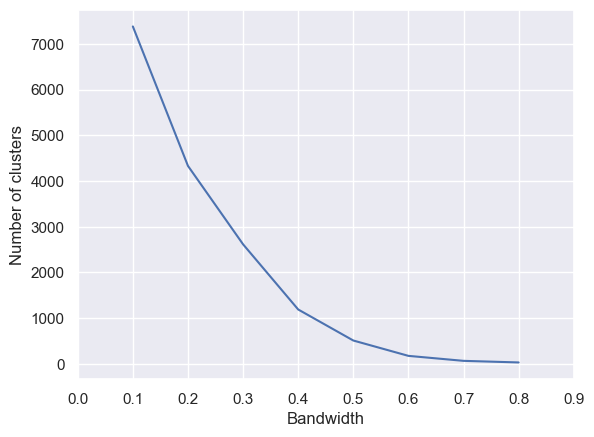

In [532]:
# Number of clusters by Bandwidth
sns.lineplot(x = bandwidth_range, y = cluster_counts)
plt.xlabel('Bandwidth')
plt.ylabel('Number of clusters')
#plt.ylim(0, 35)
plt.xlim(0, 0.9)
plt.show()

In [533]:
# Number of clusters
cluster_counts

[7382, 4330, 2614, 1188, 509, 173, 64, 29]

In [638]:
start_time = time.time()

# Model with the best bandwidth value 
ms_model = MeanShift(bandwidth = 0.8).fit(us_scaled)
    
# Predict the cluster labels: labels
ms_labels = ms_model.predict(us_scaled)

end_time = time.time()
execution_time = end_time - start_time

# Print performance metrics
print("DBSCAN execution time:", execution_time, "seconds")
    
# Number of clusters generated
cluster_no = len(set(ms_labels))
print('Number of clusters:', cluster_no)

print("Model's Silhouette score:" , silhouette_score(us_scaled, ms_labels, metric='euclidean'))
print("Model's Davies-Bouldin Index:" , davies_bouldin_score(us_scaled, ms_labels))

DBSCAN execution time: 106.37085175514221 seconds
Number of clusters: 29
Model's Silhouette score: 0.3245265872773964
Model's Davies-Bouldin Index: 1.2601159456053936


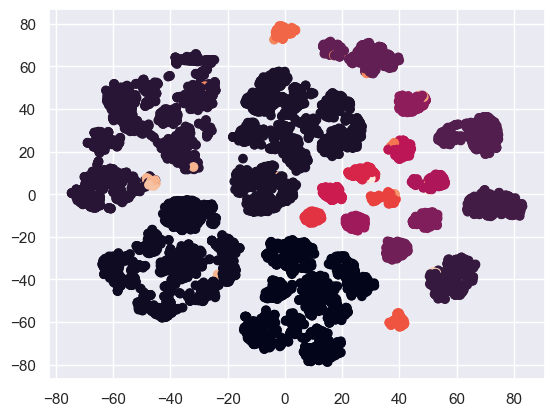

In [536]:
# Select the 0th feature
xs = tsne_features[:,0]

# Select the 1st feature
ys = tsne_features[:,1]

# Scatter plot coloued by labels
plt.scatter(xs, ys, c = ms_labels) 
plt.show()

## DBSCAN

100%|███████████████████████████████████████████| 10/10 [00:06<00:00,  1.54it/s]


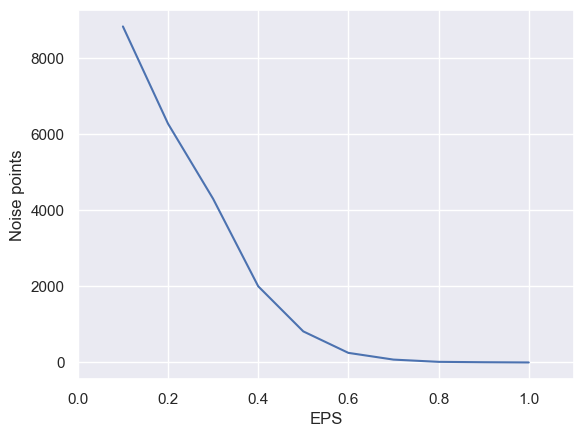

In [543]:
# Range of epsilon values
eps_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

n_clusters = []
n_noise = []

# Finding optimal epsilon value
for eps in tqdm(eps_range):
    # train the model for current value of k on training data
    db = DBSCAN(eps = eps, min_samples = 10).fit(us_scaled)

    
    # Predict the cluster labels
    db_labels = db.labels_
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
    n_clusters.append(n_clusters_)
    n_noise_ = list(db_labels).count(-1)
    n_noise.append(n_noise_)
    
sns.lineplot(x = eps_range, y = n_noise)
plt.xlabel('EPS')
plt.ylabel('Noise points')
plt.xlim(0, 1.1)
plt.show()

In [541]:
n_noise

[8839, 6282, 4306, 2005, 818, 253, 76, 17, 7, 1]

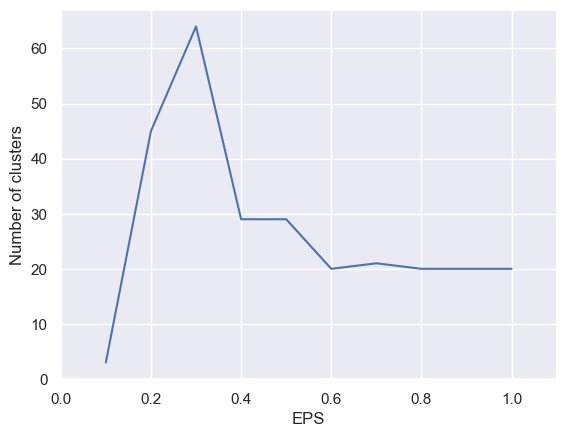

In [544]:
# Number of clusters by epsilon value
sns.lineplot(x = eps_range, y = n_clusters)
plt.xlabel('EPS')
plt.ylabel('Number of clusters')
plt.xlim(0, 1.1)
plt.show()

In [545]:
# Number of clusters
n_clusters

[3, 45, 64, 29, 29, 20, 21, 20, 20, 20]

In [639]:
start_time = time.time()

# Model with the best eps value 
db = DBSCAN(eps = 1, min_samples=10).fit(us_scaled)

# Predict the cluster labels
db_labels = db.labels_

end_time = time.time()
execution_time = end_time - start_time

# Print performance metrics
print("DBSCAN execution time:", execution_time, "seconds")

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise_ = list(db_labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Model's Silhouette score:" , silhouette_score(us_scaled, db_labels, metric='euclidean'))
print("Model's Davies-Bouldin Index:" , davies_bouldin_score(us_scaled, db_labels))

DBSCAN execution time: 0.13077592849731445 seconds
Estimated number of clusters: 20
Estimated number of noise points: 1
Model's Silhouette score: 0.3386149394973796
Model's Davies-Bouldin Index: 1.2264831085732504


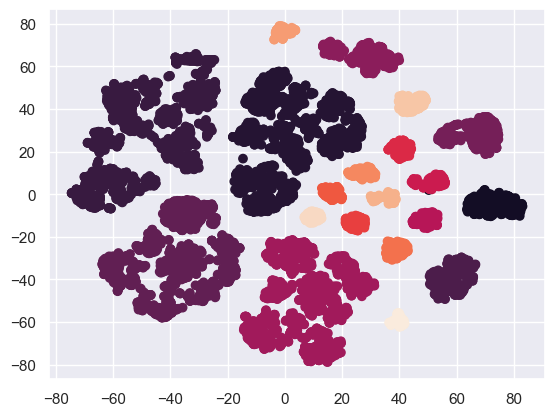

In [552]:
# Select the 0th feature
xs = tsne_features[:,0]

# Select the 1st feature
ys = tsne_features[:,1]

# Scatter plot coloured by labels
plt.scatter(xs, ys, c = db_labels) 
plt.show()

# Clustering - RFM Features

In [553]:
# RFM columns
sample_columns = ['no_orders','days_since_lo', 'total_spend']

# Create scaler
scaler = MinMaxScaler()
rfm_scaled = scaler.fit_transform(data_us[sample_columns])

## K-means

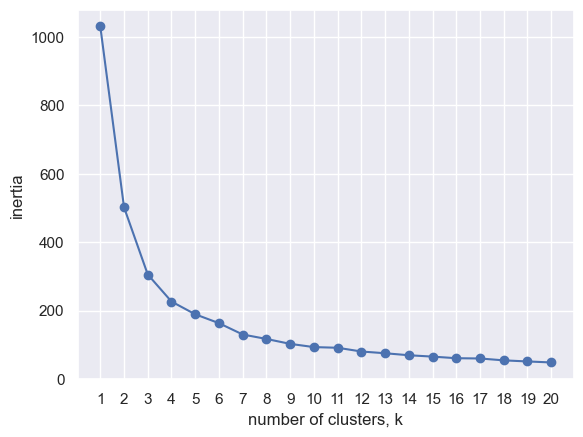

In [554]:
# Training model with RFM features
ks = range(1, 21)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters
    model = KMeans(n_clusters = k, n_init = 'auto')
    
    # Fit model to RFM features
    model.fit(rfm_scaled)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

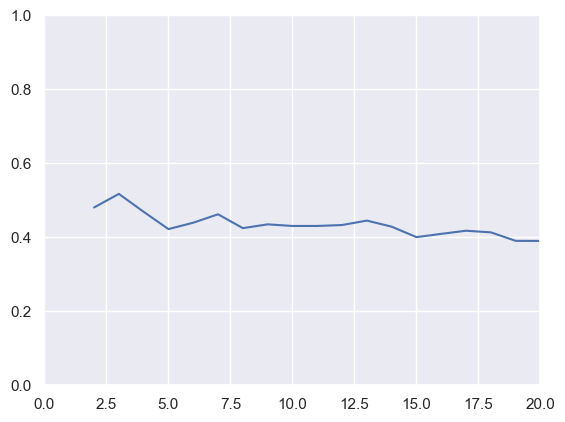

In [557]:
# Evaluation of optimal number of clusters based on silhouette score
ks = range(2, 21)
score = []


for k in ks:
    # train the model for current value of k on training data
    model = KMeans(n_clusters = k, random_state = 0, n_init='auto').fit(rfm_scaled)
    
    # Predict the cluster labels
    labels = model.predict(rfm_scaled)
    
    # Append the silhouette score to scores
    score.append(silhouette_score(rfm_scaled, labels, metric='euclidean'))
    
sns.lineplot(x = ks, y = score)
plt.ylim(0, 1)
plt.xlim(0, 20)
plt.show()

In [678]:
start_time = time.time()

# Create a KMeans instance with 8 clusters
model = KMeans(n_clusters = 6, n_init = 'auto', random_state = 42)
  
# Fit model to RFM features
model.fit(rfm_scaled)

# Predict the cluster labels: labels
labels = model.predict(rfm_scaled)

end_time = time.time()
execution_time = end_time - start_time

# Print performance metrics
print("KMeans execution time:", execution_time, "seconds")
print("Model's inertia:" , model.inertia_)
print("Model's Silhouette score:" , silhouette_score(rfm_scaled, labels, metric='euclidean'))
print("Model's Davies-Bouldin Index:" , davies_bouldin_score(rfm_scaled, ac_labels))

KMeans execution time: 0.05532693862915039 seconds
Model's inertia: 163.32043093239508
Model's Silhouette score: 0.43667813935071853
Model's Davies-Bouldin Index: 45.55511777811918


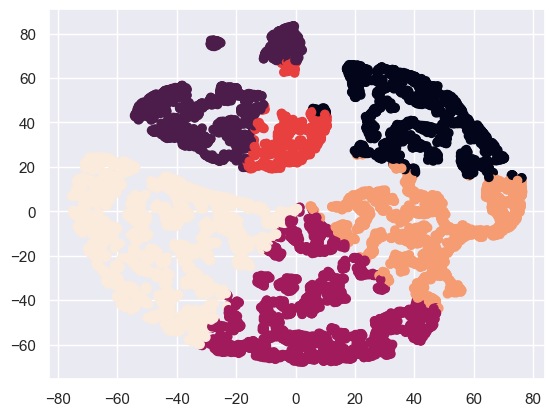

In [559]:
# Create a TSNE instance
model = TSNE(learning_rate = 100)

# Apply fit_transform to RFM features
tsne_features = model.fit_transform(rfm_scaled)

# Select the 0th feature
xs = tsne_features[:,0]

# Select the 1st feature
ys = tsne_features[:,1]

# Scatter plot coloured by cluster labels
plt.scatter(xs, ys, c = labels) 
plt.show()

## Agglomerative

In [679]:
start_time = time.time()

# Create a AgglomerativeClustering instance and fit data
ac_model = AgglomerativeClustering().fit(rfm_scaled)

# Predict labels
ac_labels = ac_model.labels_

end_time = time.time()
execution_time = end_time - start_time

# Print performance metrics
print("AgglomerativeClustering execution time:", execution_time, "seconds")

# Number of clusters generated
cluster_no = len(set(ac_labels))
print('Number of clusters:', cluster_no)
print("Model's Silhouette score:" , silhouette_score(rfm_scaled, ac_labels, metric='euclidean'))
print("Model's Davies-Bouldin Index:" , davies_bouldin_score(rfm_scaled, ac_labels))

AgglomerativeClustering execution time: 0.9013028144836426 seconds
Number of clusters: 2
Model's Silhouette score: 0.43410884154828955
Model's Davies-Bouldin Index: 0.9152374880247149


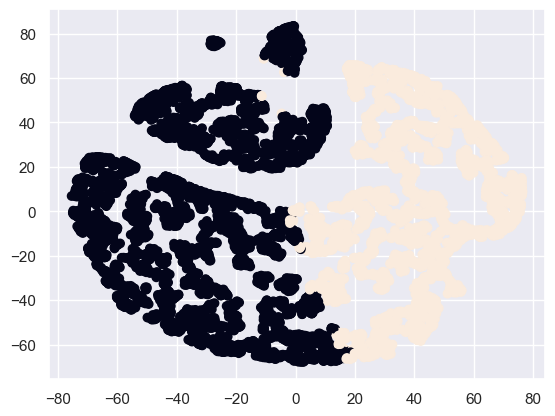

In [570]:
# Select the 0th feature
xs = tsne_features[:,0]

# Select the 1st feature 
ys = tsne_features[:,1]

# Scatter plot coloured by cluster labels
plt.scatter(xs, ys, c = ac_labels) 
plt.show()

## MeanShift

100%|█████████████████████████████████████████████| 4/4 [01:54<00:00, 28.69s/it]


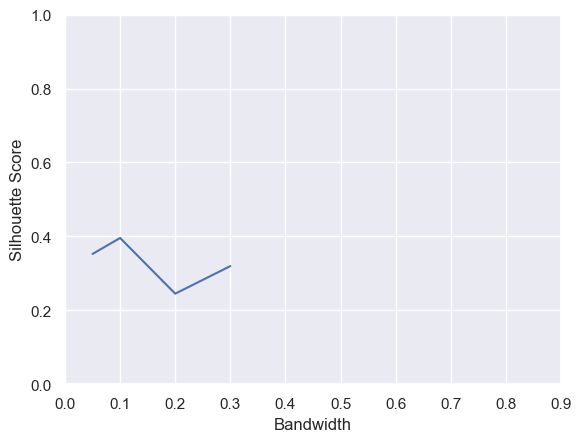

In [582]:
# Range of Bandwidth values
bandwidth_range = [0.05, 0.1, 0.2, 0.3]

score = []
cluster_counts = []

# Finding optimal Bandwidth
for bandwidth in tqdm(bandwidth_range):
    # train the model for current value of k on training data
    ms_model = MeanShift(bandwidth = bandwidth).fit(rfm_scaled)
    
    # Predict the cluster labels
    ms_labels = ms_model.predict(rfm_scaled)
    
    # Number of clusters generated
    cluster_no = len(set(ms_labels))
    cluster_counts.append(cluster_no)
    
    # Append the silhouette score to scores
    score.append(silhouette_score(rfm_scaled, ms_labels, metric='euclidean'))
    
sns.lineplot(x = bandwidth_range, y = score)
plt.xlabel('Bandwidth')
plt.ylabel('Silhouette Score')
plt.ylim(0, 1)
plt.xlim(0, 0.9)
plt.show()

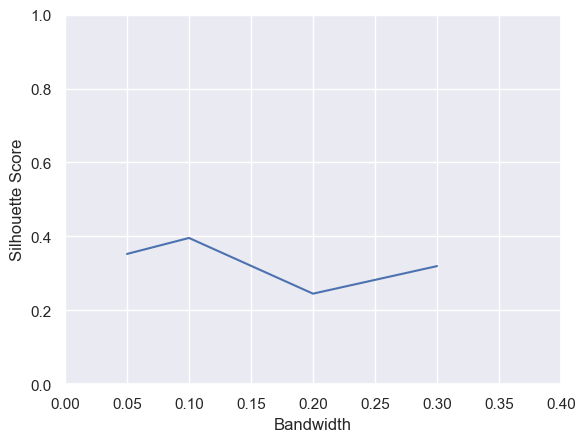

In [583]:
# Silhouette Score by Bandwidth
sns.lineplot(x = bandwidth_range, y = score)
plt.xlabel('Bandwidth')
plt.ylabel('Silhouette Score')
plt.ylim(0, 1)
plt.xlim(0, 0.4)
plt.show()

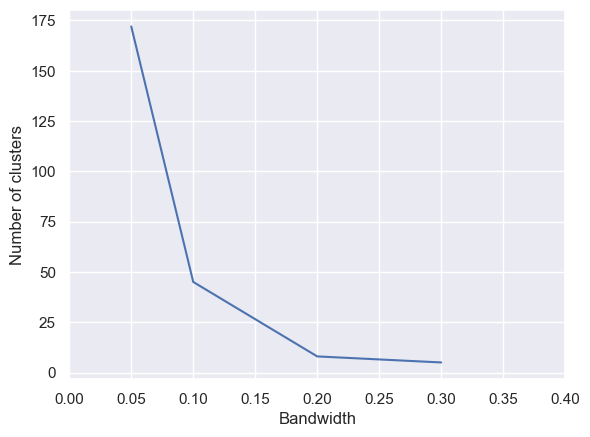

In [585]:
# Number of clusters by Bandwidth
sns.lineplot(x = bandwidth_range, y = cluster_counts)
plt.xlabel('Bandwidth')
plt.ylabel('Number of clusters')
#plt.ylim(0, 35)
plt.xlim(0, 0.4)
plt.show()

In [586]:
# Number of clusters
cluster_counts

[172, 45, 8, 5]

In [680]:
start_time = time.time()

# Model with the best bandwidth value 
ms_model = MeanShift(bandwidth = 0.3).fit(rfm_scaled)
    
# Predict the cluster labels: labels
ms_labels = ms_model.predict(rfm_scaled)

end_time = time.time()
execution_time = end_time - start_time

# Print performance metrics
print("MeanShift execution time:", execution_time, "seconds")

# Number of clusters generated
cluster_no = len(set(ms_labels))
print('Number of clusters:', cluster_no)
print("Model's Silhouette score:" , silhouette_score(rfm_scaled, ms_labels, metric='euclidean'))
print("Model's Davies-Bouldin Index:" , davies_bouldin_score(rfm_scaled, ms_labels))

MeanShift execution time: 14.070780038833618 seconds
Number of clusters: 5
Model's Silhouette score: 0.31967163365247836
Model's Davies-Bouldin Index: 1.0703998287341903


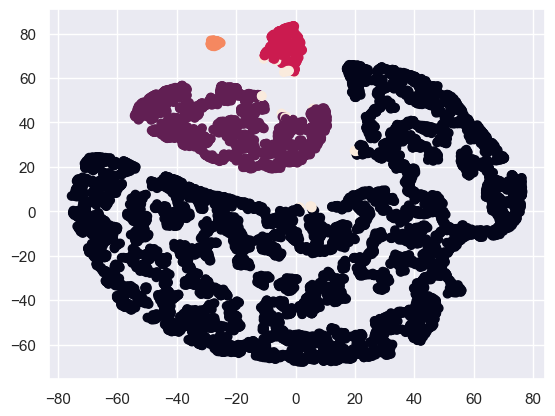

In [588]:
# Select the 0th feature
xs = tsne_features[:,0]

# Select the 1st feature
ys = tsne_features[:,1]

# Scatter plot coloured by cluster labels
plt.scatter(xs, ys, c = ms_labels) 
plt.show()

## DBSCAN

100%|███████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


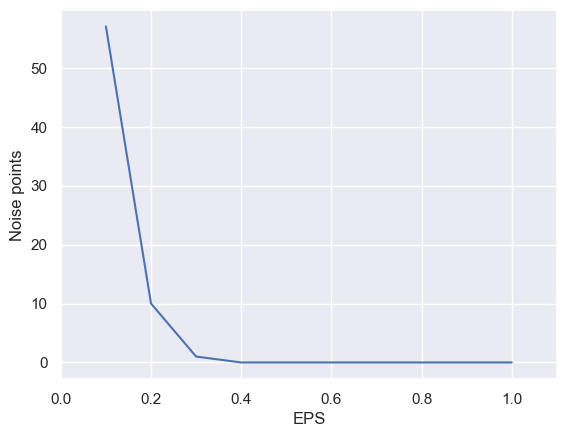

In [597]:
# Range of epsilon values
eps_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

n_clusters = []
n_noise = []

# Finding optimal epsilon 
for eps in tqdm(eps_range):
    # train the model for current value of k on training data
    db = DBSCAN(eps = eps, min_samples = 10).fit(rfm_scaled)

    
    # Predict the cluster labels
    db_labels = db.labels_
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
    n_clusters.append(n_clusters_)
    n_noise_ = list(db_labels).count(-1)
    n_noise.append(n_noise_)
    
# Noise points by epsilon value   
sns.lineplot(x = eps_range, y = n_noise)
plt.xlabel('EPS')
plt.ylabel('Noise points')
plt.xlim(0, 1.1)
plt.show()

In [598]:
# Noise points
n_noise

[57, 10, 1, 0, 0, 0, 0, 0, 0, 0]

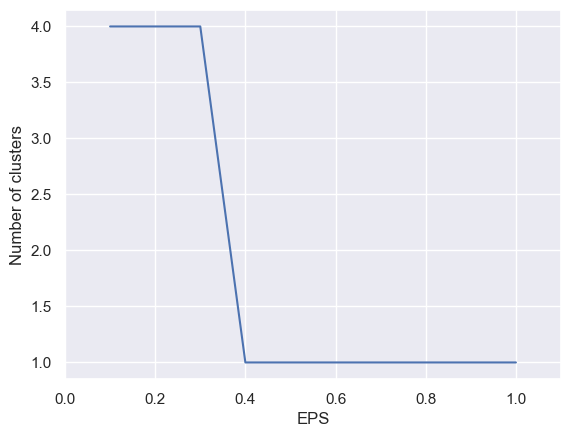

In [599]:
# Number of clusters by epsilon value   
sns.lineplot(x = eps_range, y = n_clusters)
plt.xlabel('EPS')
plt.ylabel('Number of clusters')
plt.xlim(0, 1.1)
plt.show()

In [681]:
start_time = time.time()

# Model with the best eps value 
db = DBSCAN(eps = 0.3, min_samples=10).fit(rfm_scaled)

# Predict the cluster labels
db_labels = db.labels_

end_time = time.time()
execution_time = end_time - start_time

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise_ = list(db_labels).count(-1)

# Print performance metrics
print("DBSCAN execution time:", execution_time, "seconds")
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Model's Silhouette score:" , silhouette_score(rfm_scaled, db_labels, metric='euclidean'))
print("Model's Davies-Bouldin Index:" , davies_bouldin_score(rfm_scaled, db_labels))

DBSCAN execution time: 0.3316962718963623 seconds
Estimated number of clusters: 4
Estimated number of noise points: 1
Model's Silhouette score: 0.32059609550345874
Model's Davies-Bouldin Index: 0.940126232449083


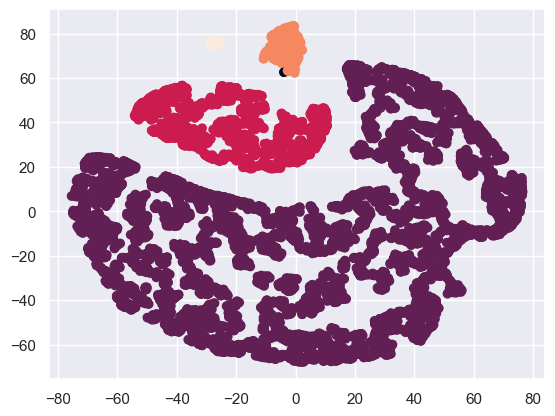

In [601]:
# Select the 0th feature
xs = tsne_features[:,0]

# Select the 1st feature
ys = tsne_features[:,1]

# Scatter plot coloured by cluster labels
plt.scatter(xs, ys, c = db_labels) 
plt.show()

### RFM Cluster analysis

In [683]:
# Create dataframe with RFM data
us_rfm_df = data_us[sample_columns]

# Add columns with scaled RFM features
us_rfm_df.loc[:, 'f_scaled'] = rfm_scaled[:, [0]]
us_rfm_df.loc[:, 'r_scaled'] = rfm_scaled[:, [1]]
us_rfm_df.loc[:, 'm_scaled'] = rfm_scaled[:, [2]]

# Add columns with labels for each model
us_rfm_df['km_labels'] = labels
us_rfm_df['ac_labels'] = ac_labels
us_rfm_df['ms_labels'] = ms_labels
us_rfm_df['db_labels'] = db_labels

us_rfm_df.head()

no_orders  days_since_lo  total_spend  f_scaled  r_scaled  m_scaled  \
0          1          118.0        54.00       0.0  0.160494  0.042762   
1          1          109.0        80.00       0.0  0.148148  0.063944   
2          1          584.0        13.64       0.0  0.799726  0.009882   
3          1          270.0        94.00       0.0  0.368999  0.075349   
4          1          376.0       140.00       0.0  0.514403  0.112825   

   km_labels  ac_labels  ms_labels  db_labels  
0          5          0          0          0  
1          5          0          0          0  
2          0          1          0          0  
3          2          1          0          0  
4          4          1          0          0

In [685]:
# Cluster size for K-means
us_rfm_df[['km_labels', 'no_orders']].groupby('km_labels').count()

no_orders
km_labels           
0               1308
1               1154
2               1878
3                553
4               1554
5               2442

In [686]:
# Descriptive statistics for K-means
us_rfm_df.groupby('km_labels')[sample_columns].mean()

no_orders  days_since_lo  total_spend
km_labels                                       
0           1.019113     616.117737    91.347011
1           2.266898      80.036395   195.145070
2           1.000000     231.703940    88.281358
3           2.083183     332.602170   177.669476
4           1.000000     416.642857    90.217317
5           1.000000      66.919328    83.185258

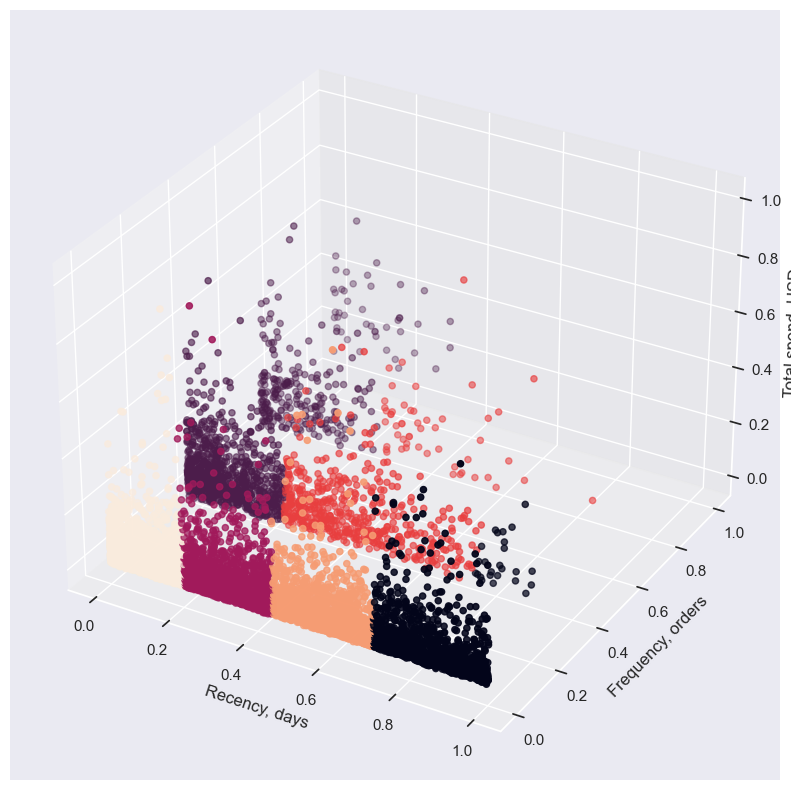

In [689]:
# Visualising US data on 3D plot for RFM coloured by K-means
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.set_size_inches(14, 10)

ax.scatter(us_rfm_df['r_scaled'],us_rfm_df['f_scaled'], us_rfm_df['m_scaled'], 
           c = us_rfm_df['km_labels'])
ax.set_xlabel('Recency, days')
ax.set_ylabel('Frequency, orders')
ax.set_zlabel('Total spend, USD')
plt.show()